This notebook is the first part of a tutorial on Time Series Analysis using StatsModels.

It is based on Chapter 12 of [*Think Stats*, third edition](https://allendowney.github.io/ThinkStats/).

# Time series analysis

A **time series** is a sequence of measurements from a system that varies in time.
Many of the tools we used in previous chapters, like regression, can also be used with time series.
But there are additional methods that are particularly useful for this kind of data.

As examples, we'll look at two datasets: renewable electricity generation in the United States from 2001 to 2024, and weather data over the same interval.
We will develop methods to decompose a time series into a long-term trend and a repeated seasonal component.
We'll use linear regression models to fit and forecast trends.
And we'll try out a widely-used model for analyzing time series data, with the formal name "autoregressive integrated moving average" and the easier-to-say acronym ARIMA.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/tutorial/ts/time_series_01.ipynb).

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## Electricity

As an example of time-series data, we'll use a dataset from the U.S. Energy Information Administration -- it includes total electricity generation per month from renewable sources from 2001 to 2024.

In [4]:
# The following cell downloads the data, which I downloaded September 17, 2024
# from https://www.eia.gov/electricity/data/browser/

In [5]:
filename = "Net_generation_for_all_sectors.csv"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

After loading the data, we have make some transformations to get it into a format that's easy to work with.

In [6]:
elec = (
    pd.read_csv("Net_generation_for_all_sectors.csv", skiprows=4)
    .drop(columns=["units", "source key"])
    .set_index("description")
    .replace("--", np.nan)
    .transpose()
    .astype(float)
)

In the reformatted dataset, each column is a sequence of monthly totals in gigawatt-hours (GWh).
Here are the column labels, showing the different sources of electricity, or "sectors".

In [7]:
elec.columns

Index(['Net generation for all sectors', 'United States',
       'United States : all fuels (utility-scale)', 'United States : nuclear',
       'United States : conventional hydroelectric',
       'United States : other renewables', 'United States : wind',
       'United States : all utility-scale solar', 'United States : geothermal',
       'United States : biomass',
       'United States : hydro-electric pumped storage',
       'United States : all solar',
       'United States : small-scale solar photovoltaic'],
      dtype='object', name='description')

The labels in the index are strings indicating months and years -- here are the first 12.

In [8]:
elec.index[:12]

Index(['Jan 2001', 'Feb 2001', 'Mar 2001', 'Apr 2001', 'May 2001', 'Jun 2001',
       'Jul 2001', 'Aug 2001', 'Sep 2001', 'Oct 2001', 'Nov 2001', 'Dec 2001'],
      dtype='object')

It will be easier to work with this data if we replace these strings with Pandas `Timestamp` objects.
We can use the `date_range` function to generate a sequence of `Timestamp` objects, starting in January 2001 with the frequency code "ME", which stands for "month end", so it fills in the last day of each month.

In [9]:
elec.index = pd.date_range(start="2001-01", periods=len(elec), freq="ME")
elec.index[:6]

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30'],
              dtype='datetime64[ns]', freq='ME')

Now the index is a `DataTimeIndex` with the data type `datetime64[ns]`, which is defined in NumPy -- `64` means each one uses 64 bits, and `ns` means it has nanosecond precision. 

## Decomposition

As a first example, we'll look at how electricity generation from nuclear reactors has changed over from January 2001 to June 2024, and we'll decompose the time series into a long-term trend and a periodic component.
Here are monthly totals of electricity generation from nuclear reactors in the United States. 

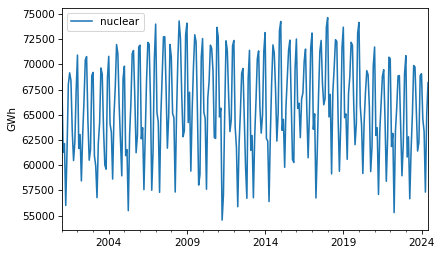

In [10]:
nuclear = elec["United States : nuclear"]
nuclear.plot(label="nuclear")

decorate(ylabel="GWh")

It looks like there are some increases and decreases, but they are hard to see clearly because there are large variations from month to month.
To see the long-term trend more clearly, we can use the `rolling` and `mean` methods to compute a **moving average**.

In [11]:
trend = nuclear.rolling(window=12).mean()

The `window=12` argument means it should select overlapping intervals of 12 months, so the first interval contains 12 measurements starting with the first, the second interval contains 12 measurements starting with the second, and so on.
For each interval, we compute the mean of the measurements.

Here's what the results look like, along with the original data.

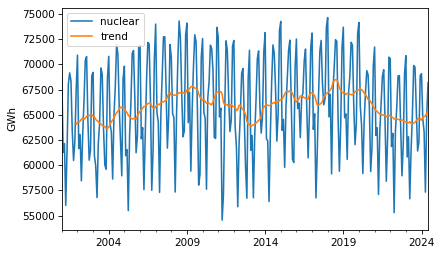

In [12]:
nuclear.plot(label="nuclear")
trend.plot(label="trend")
decorate(ylabel="GWh")

The trend is still quite variable.
We could smooth it more by using a longer window, but we'll stick with the 12-month window for now.

If we subtract the trend from the original data, the result is a "detrended" time series, which means that the long-term mean is close to constant.
Here's what it looks like.

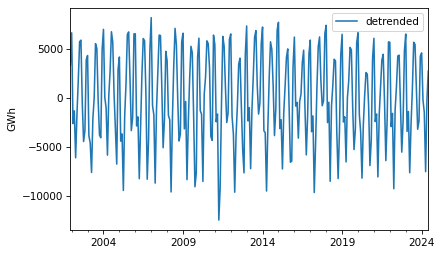

In [13]:
detrended = (nuclear - trend).dropna()
detrended.plot(label="detrended")
decorate(ylabel="GWh")

It seems like there is a repeating annual pattern, which makes sense because demand for electricity varies from one season to another, as it is used to generate heat in the winter and run air conditioning in the summer.
To describe this annual pattern we can group the data by month and compute average production.
Here's what the monthly averages look like.

In [14]:
monthly_averages = detrended.groupby(detrended.index.month).mean()

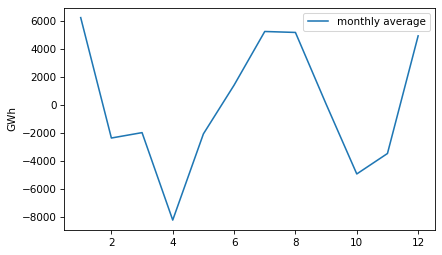

In [15]:
monthly_averages.plot(label="monthly average")
decorate(ylabel="GWh")

Electricity production is highest during the coldest and warmest months.

We can use `monthly_averages` to construct the seasonal component of the data, which is a series the same length as `nuclear`, where the element for each month is the average for that month.
Here's what it looks like.

In [16]:
seasonal = monthly_averages[nuclear.index.month]

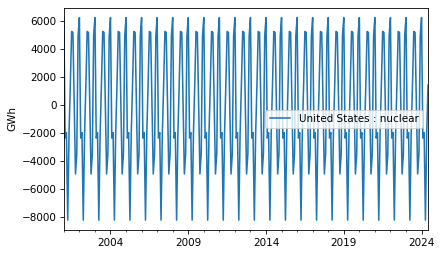

In [17]:
seasonal.index = nuclear.index
seasonal.plot()
decorate(ylabel="GWh")

Each 12-month period is identical to the others.

The sum of the trend and the seasonal component represents the expected value for each month.

In [18]:
expected = trend + seasonal

Here's what it looks like compared to the original series.

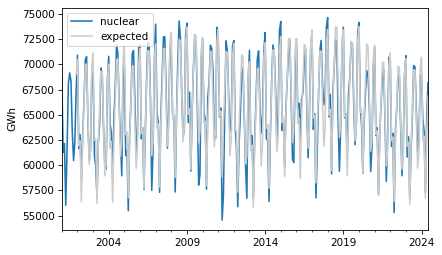

In [19]:
nuclear.plot(label="nuclear")
expected.plot(color="0.8", label="expected")
decorate(ylabel="GWh")

If we subtract this sum from the original series, the result is the residual component, which represents the departure from the expected value for each month.

In [20]:
resid = nuclear - expected

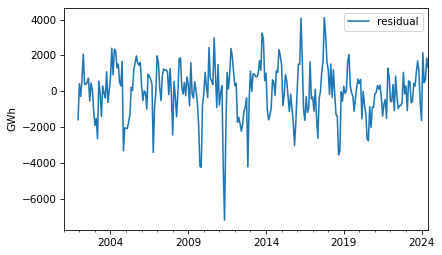

In [21]:
resid.plot(label="residual")
decorate(ylabel="GWh")

We can think of the residual as the sum of everything in the world that affects energy production, but is not explained by the long-term trend or the seasonal component.
Among other things, that sum includes weather, equipment that's down for maintenance, and changes in demand due to specific events.
Since the residual is the sum of many unpredictable, and sometimes unknowable, factors, we often treat it as a random quantity.

Here's what the distribution of the residuals look like.

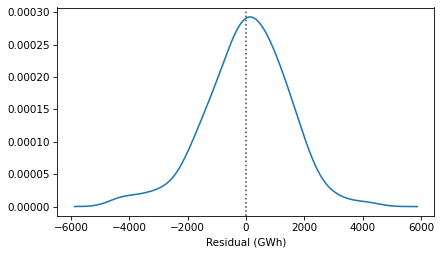

In [22]:
from thinkstats import plot_kde

plot_kde(resid.dropna())
decorate(xlabel="Residual (GWh)")

It resembles the bell curve of the normal distribution, which is consistent with the assumption that it is the sum of many random contributions.

To quantify how well this model describes the original series, we can compute the coefficient of determination, which indicates how much smaller the variance of the residuals is, compared to the variance of the original series.

In [23]:
rsquared = 1 - resid.var() / nuclear.var()
rsquared

0.9054559977517084

The $R^2$ value is about 0.92, which means that the long-term trend and seasonal component account for 92% of the variability in the series.
This $R^2$ is substantially higher than the ones we saw in the previous chapter, but that's common with time series data -- especially in a case like this where we've constructed the model to resemble the data. 

The process we've just walked through is called **seasonal decomposition**.
StatsModels provides a function that does it, called `seasonal_decompose`.

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(nuclear, model="additive", period=12)

The `model="additive"` argument indicates the additive model, so the series is decomposed into the sum of a trend, seasonal component, and residual.
We'll see the multiplicative model soon.
The `period=12` argument indicates that the duration of the seasonal component is 12 months.

The result is an object that contains the three components.
We'll use the following function to plots them.

In [25]:
def plot_decomposition(original, decomposition):
    plt.figure(figsize=(6, 5))

    plt.subplot(4, 1, 1)
    plt.plot(original, label="Original", color="C0")
    plt.ylabel("Original")

    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label="Trend", color="C1")
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label="Seasonal", color="C2")
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label="Residual", color="C3")
    plt.ylabel("Residual")

    plt.tight_layout()

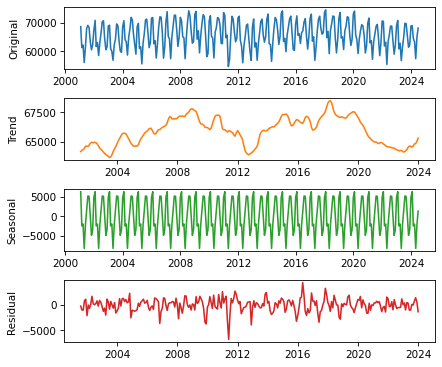

In [26]:
plot_decomposition(nuclear, decomposition)

The results are similar to those computed ourselves, with small differences due to the details of the implementation.

This kind of seasonal decomposition provides insight into the structure of a time series.
As we'll see in the next section, it is also useful for making forecasts.

### Exercise

As an example of seasonal decomposition, let's model monthly average surface temperatures in the United States.
We'll use a dataset from Our World in Data that includes "temperature [in Celsius] of the air measured 2 meters above the ground, encompassing land, sea, and in-land water surfaces," for most countries in the world from 1941 to 2024.

In [63]:
# The following cell downloads data prepared by Our World in Data,
# from https://ourworldindata.org/grapher/average-monthly-surface-temperature

# Based on modified data from Copernicus Climate Change Service information (2019)
# with "major processing" by Our World in Data

The following cells download and display the metadata that describes the dataset.

In [66]:
import requests

# Define the URL
url = "https://ourworldindata.org/grapher/average-monthly-surface-temperature.metadata.json"
query_params = {
    "v": "1",
    "csvType": "full",
    "useColumnShortNames": "true"
}
headers = {'User-Agent': 'Our World In Data data fetch/1.0'}

# Send the GET request with the query parameters
response = requests.get(url, params=query_params, headers=headers)
data = response.json()

In [67]:
from pprint import pprint

pprint(data['columns']['temperature_2m'])

{'citationLong': 'Contains modified Copernicus Climate Change Service '
                 'information (2019) – with major processing by Our World in '
                 'Data. “Annual average” [dataset]. Contains modified '
                 'Copernicus Climate Change Service information, “ERA5 monthly '
                 'averaged data on single levels from 1940 to present 2” '
                 '[original data].',
 'citationShort': 'Contains modified Copernicus Climate Change Service '
                  'information (2019) – with major processing by Our World in '
                  'Data',
 'descriptionKey': [],
 'descriptionProcessing': '- Temperature measured in kelvin was converted to '
                          'degrees Celsius (°C) by subtracting 273.15.\n'
                          '\n'
                          '- Initially, the temperature dataset is provided '
                          'with specific coordinates in terms of longitude and '
                          'latitude. To

The following cells download the data for one country -- feel free to change `country_code` if you would like to see data from another country.
Use [three-letter ISO 3166 country codes](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes#Current_ISO_3166_country_codes).

In [28]:
country_code = 'USA'    # replace this with other three-letter country codes
base_url = "https://ourworldindata.org/grapher/average-monthly-surface-temperature.csv"

query_params = {
    "v": "1",
    "csvType": "filtered",
    "useColumnShortNames": "true",
    "tab": "chart",
    "country": country_code  
}

In [29]:
from urllib.parse import urlencode

url = f"{base_url}?{urlencode(query_params)}"
temp_df = pd.read_csv(url, storage_options=headers)

In [30]:
temp_df.head()

,Entity,Code,year,Day,temperature_2m,temperature_2m.1
0,United States,USA,1941,1941-12-15,-1.878019,8.016244
1,United States,USA,1942,1942-01-15,-4.776551,7.848984
2,United States,USA,1942,1942-02-15,-3.870868,7.848984
3,United States,USA,1942,1942-03-15,0.097811,7.848984
4,United States,USA,1942,1942-04-15,7.537291,7.848984


The `DataFrame` includes the column that's documented in the metadata, `temperature_2m`, and an additional undocumented column.
It looks like it might be an annual average.
For this example, we'll use the monthly data.

In [61]:
temp_series = temp_df['temperature_2m']
temp_series.index = pd.to_datetime(temp_df['Day'])

Here's what it looks like.

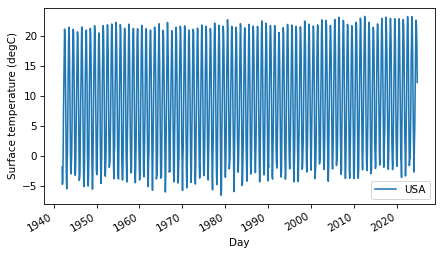

In [62]:
temp_series.plot(label=country_code)
decorate(ylabel="Surface temperature (degC)")

Not surprisingly, there is a strong seasonal pattern.
Compute an additive seasonal decomposition with a period of 12 months, and use `seasonal_decompose` to plot the results.
Compute the $R^2$ value of the fitted model.

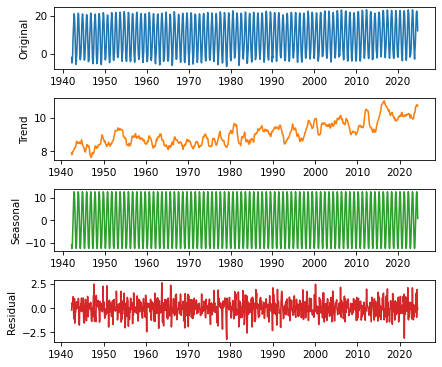

In [33]:
# Solution

decomposition = seasonal_decompose(temp_series, model="additive", period=12)
plot_decomposition(temp_series, decomposition)

In [34]:
# Solution

rsquared = 1 - decomposition.resid.var() / temp_series.var()
rsquared

0.9918635651884932

## Prediction

We can use the results from seasonal decomposition to predict the future.
To demonstrate, we'll use the following function to split the time series into a training series we'll use to generate predictions and a test series we'll use to see whether they are accurate. 

In [35]:
def split_series(series, n=60):
    training = series.iloc[:-n]
    test = series.iloc[-n:]
    return training, test

With `n=60`, the duration of the test series is five years, starting in July 2019.

In [36]:
training, test = split_series(nuclear)
test.index[0]

Timestamp('2019-07-31 00:00:00')

Now, suppose it's June 2019 and you are asked to generate a five-year forecast for electricity production from nuclear generators.
To answer this question, we'll start with a seasonal decomposition of the training data.

In [37]:
decomposition = seasonal_decompose(training, model="additive", period=12)
trend = decomposition.trend

Now we'll fit a linear model to the trend.
The dependent variable, `months`, is the number of months from the beginning of the series.

In [38]:
import statsmodels.formula.api as smf

months = np.arange(len(trend))
data = pd.DataFrame({"trend": trend, "months": months}).dropna()
results = smf.ols("trend ~ months", data=data).fit()

Here is a summary of the results.

In [39]:
from thinkstats import display_summary

display_summary(results)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.482e+04,131.524,492.869,0.000,6.46e+04,6.51e+04
months,10.9886,1.044,10.530,0.000,8.931,13.046


R-squared:,0.3477


The $R^2$ value is about 0.35, which suggests that the model does not fit the data particularly well.
We can get a better sense of that by plotting the fitted line.
We'll use the `predict` method to retrodict the values in the training data and predict the values in the test data.

In [40]:
months = np.arange(len(training) + len(test))
df = pd.DataFrame({"months": months})
pred_trend = results.predict(df)
pred_trend.index = nuclear.index

Here's the trend component and the linear model.

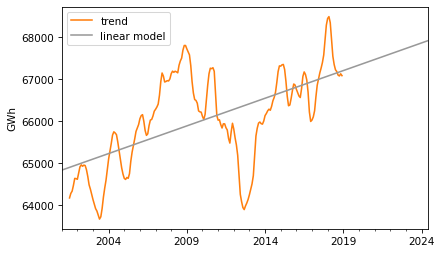

In [41]:
trend.plot(color="C1")
pred_trend.plot(color="0.6", label="linear model")
decorate(ylabel="GWh")

There's a lot going on that's not captured by the linear model, but it looks like there is a generally increasing trend.

Next we'll use the seasonal component from the decomposition to compute a `Series` of monthly averages.

In [42]:
seasonal = decomposition.seasonal
monthly_averages = seasonal.groupby(seasonal.index.month).mean()

We can predict the seasonal component by looking up the dates from the fitted line in `monthly_averages`.

In [43]:
pred_seasonal = monthly_averages[pred_trend.index.month]
pred_seasonal.index = pred_trend.index

Finally, to generate predictions, we'll add the seasonal component to the trend.

In [44]:
pred = pred_trend + pred_seasonal

Here's the training data and the predictions.

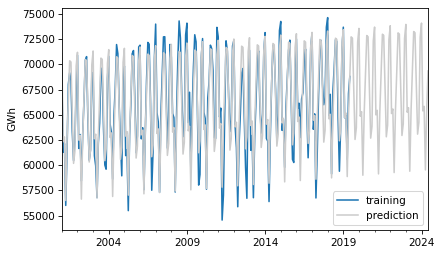

In [45]:
training.plot(label="training")
pred.plot(color="0.8", label="prediction")
decorate(ylabel="GWh")

The predictions fit the training data reasonably well, and the forecast looks like a reasonable projection, based on the assumption that the long-term trend will continue.

Now, from the vantage point of the future, let's see how accurate this forecast turned out to be.
Here is are the predicted and actual values for the five-year interval from July 2019. 

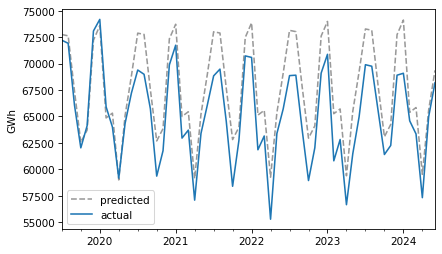

In [46]:
forecast = pred[test.index]
forecast.plot(ls="--", color="0.6", label="predicted")
test.plot(label="actual")
decorate(ylabel="GWh")

The first year of the forecast was pretty good, but production from nuclear reactors in 2020 was lower than expected -- probably due to the COVID-19 pandemic -- and it never returned to the long-term trend.

To quantify the accuracy of the predictions, we'll use the mean absolute percentage error (MAPE), which the following function computes.

In [47]:
def MAPE(predicted, actual):
    ape = np.abs(predicted - actual) / actual
    return np.mean(ape) * 100

In this example, the predictions are off by 3.81% on average.

In [48]:
MAPE(forecast, test)

3.811940747879257

We'll come back to this example later and see if we can do better with a different model.

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)